# Generating a bidirectional GRU model and a unidirectional LSTM model to determine which tweet is relevant to be a news story. And assess a couple of sequence model architectures


## Importing all the required dependencies

In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
import nltk.classify.util
import string
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.util import *
import re
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, Dropout, Bidirectional, SpatialDropout1D, LSTM,  Activation



## Reading the data from google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
news_df = pd.read_excel("drive/My Drive/Data/news-text-sanitized.xlsx")
news_df.head()

,Category,Confidence,Tweet
0,Not Relevant,1.0,Hey! How are you?
1,Not Relevant,1.0,What's up man?
2,Not Relevant,1.0,I love fruits
3,Not Relevant,1.0,Summer is lovely
4,Not Relevant,1.0,My car is so fast


In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10323 entries, 0 to 10322
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Category    10323 non-null  object 
 1   Confidence  10323 non-null  float64
 2   Tweet       10323 non-null  object 
dtypes: float64(1), object(2)
memory usage: 242.1+ KB


Category
Can't Decide      16
Not Relevant    5931
Relevant        4376
Name: Confidence, dtype: int64


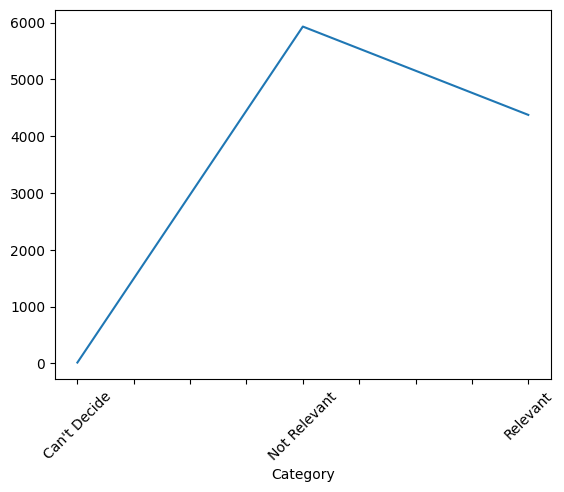

In [ ]:
import matplotlib.pyplot as plt


df1 = news_df.groupby(['Category']).count()['Confidence']
print(df1)

# plot the result
df1.plot()
plt.xticks(rotation=45)
plt.show()

<Axes: >

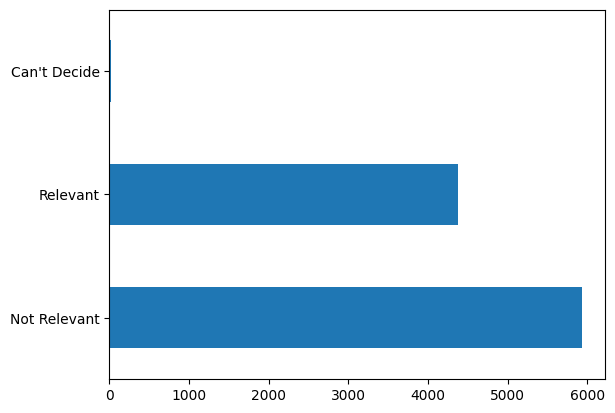

In [ ]:
news_df['Category'].value_counts()[:20].plot(kind='barh')


## Data Preprocessing stage starts here

Data preprocessing is performed inorder to generate an accurate final result.
The given data might not be clean always so it is importent to perform data preprocesing

In [ ]:
import re

def word_cleaning(text):
    regex = re.compile(r'<[^>]+>')
    return regex.sub('', text)

news_df['Tweet'] = news_df['Tweet'].apply(word_cleaning)

news_df.Tweet

0                                        Hey! How are you?
1                                           What's up man?
2                                            I love fruits
3                                         Summer is lovely
4                                        My car is so fast
                               ...                        
10318                          Make man pikin crash ??????
10319    Disregard my snap story there is an angry whit...
10320    #tornado #singapore Mac and #cheese #around th...
10321    Check out more data on Upper Wabash reservoirs...
10322    Drowning' - Acrylic 08.05.15 https://t.co/X17f...
Name: Tweet, Length: 10323, dtype: object

## **In order to convert lables(in our case Category) in to binary values or binary lables we are using LabelBinarizer**

In [ ]:


label_binarizer = LabelBinarizer()
label_binarizer.fit(news_df.Category)
labels = label_binarizer.classes_
labels



array(["Can't Decide", 'Not Relevant', 'Relevant'], dtype='<U12')

In [ ]:
# Defing the maximum length and maximun words
# This can be decreased inorder to reduce the traning time

m_len = 100
m_word = 8000

token = Tokenizer(num_words=m_word, lower=True)
token.fit_on_texts(news_df.Tweet)


In [ ]:
#In order to make sure that all the sequences in a list have the same length we are using pad_sequences
#WE are passing 100 as the maximum length for the pad_sequences

sequences = token.texts_to_sequences(news_df.Tweet)
X_pad = pad_sequences(sequences, maxlen=m_len, padding='post')
print(X_pad.shape)


(10323, 100)


# Now we are splitting the data in to test and train using train_test_split

In [ ]:
# Here we are using X_pad (the sequence which we got after performing pad_sequences)as x and Category as y
# here 25% data will be test part and rest will be in train part

y = label_binarizer.transform(news_df.Category)

x_train, x_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.25, random_state=1000)

## Model building starts here

# First model : Bidirectional GRU

In [ ]:
# Bidirectional GRU is also known as BiGRU
# It consist of input and forget gates

model1 = Sequential()

# adding embedding layer
model1.add(Embedding(m_word, 125, input_length=m_len))
model1.add(SpatialDropout1D(0.2))
model1.add(Bidirectional(GRU(75)))
#dropout layer added
model1.add(Dropout(0.2))

# Adding dense layer along with actiavtion function
model1.add(Dense(3, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 125)          1000000   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 100, 125)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_3 (Bidirectio  (None, 150)              90900     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 453       
                                                                 
Total params: 1,091,353
Trainable params: 1,091,353
No

In [ ]:
x_train.reshape((-1,1))
y_train.reshape((-1,1))


array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [ ]:
BiGRU = model1.fit(x_train, y_train,
                    # class_weight=class_weight,
                    epochs=1,
                    batch_size=32,
                    validation_split=0.1 )

218/218 [==============================] - 36s 117ms/step - loss: 0.3916 - categorical_accuracy: 0.7056 - val_loss: 0.3000 - val_categorical_accuracy: 0.8000


The val_categorical_accuracy accuracy is 80% with a single epoche which is not good technically




In [ ]:
y_pred = model1.predict(x_test)
validation = model1.evaluate(x_test, y_test)

print(model1.metrics_names[0], validation[0])
print(model1.metrics_names[1], validation[1])

81/81 [==============================] - 1s 6ms/step - loss: 0.3212 - categorical_accuracy: 0.7846
loss 0.32116687297821045
categorical_accuracy 0.7845796346664429


In [ ]:
from sklearn.metrics import classification_report
pred = (y_pred > 0.5)
print(classification_report(y_test, pred,target_names=labels))

              precision    recall  f1-score   support

Can't Decide       0.00      0.00      0.00         6
Not Relevant       0.79      0.86      0.82      1477
    Relevant       0.77      0.70      0.73      1098

   micro avg       0.78      0.79      0.78      2581
   macro avg       0.52      0.52      0.52      2581
weighted avg       0.78      0.79      0.78      2581
 samples avg       0.78      0.79      0.78      2581



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, pred, labels=None, sample_weight=None)

array([[[2575,    0],
        [   6,    0]],

       [[ 760,  344],
        [ 213, 1264]],

       [[1257,  226],
        [ 332,  766]]])

## Second model : unidirectional LSTM

In [ ]:
model2 = Sequential()

model2.add(Embedding(m_word, output_dim=45, input_length=m_len))
model2.add(LSTM(128, return_sequences=True))
#dropout layer added
model2.add(Dropout(0.5))

# secong layer added with one dropout layer
model2.add(LSTM(64))
model2.add(Dropout(0.5))

#Dense output layer with activation function added
model2.add(Dense(3))
model2.add(Activation('softmax'))


model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
model2.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 100, 45)           360000    
                                                                 
 lstm_36 (LSTM)              (None, 100, 128)          89088     
                                                                 
 dropout_40 (Dropout)        (None, 100, 128)          0         
                                                                 
 lstm_37 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_41 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 3)                 195       
                                                                 
 activation_1 (Activation)   (None, 3)               

In [ ]:
x_train.reshape((-1,1))
y_train.reshape((-1,1))

array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [ ]:
UniLSTM = model2.fit(x_train, y_train,
                    epochs=1,
                    batch_size=32,
                    validation_split=0.1 )

218/218 [==============================] - 38s 148ms/step - loss: 0.4874 - categorical_accuracy: 0.5420 - val_loss: 0.4639 - val_categorical_accuracy: 0.5600


The val_categorical_accuracy accuracy is 56% with a single epoche

In [ ]:
y_pred = model2.predict(x_test)
validation = model2.evaluate(x_test, y_test)

print(model2.metrics_names[0], validation[0])
print(model2.metrics_names[1], validation[1])

81/81 [==============================] - 0s 6ms/step - loss: 0.4621 - categorical_accuracy: 0.5723
loss 0.4621172845363617
categorical_accuracy 0.5722588300704956


In [ ]:
pred = (y_pred > 0.5)
print(classification_report(y_test, pred,target_names=labels))

              precision    recall  f1-score   support

Can't Decide       0.00      0.00      0.00         6
Not Relevant       0.57      1.00      0.73      1477
    Relevant       0.00      0.00      0.00      1098

   micro avg       0.57      0.57      0.57      2581
   macro avg       0.19      0.33      0.24      2581
weighted avg       0.33      0.57      0.42      2581
 samples avg       0.57      0.57      0.57      2581



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
multilabel_confusion_matrix(y_test, pred, labels=None, sample_weight=None)

array([[[2575,    0],
        [   6,    0]],

       [[   0, 1104],
        [   0, 1477]],

       [[1483,    0],
        [1098,    0]]])

In [ ]:
%%shell
jupyter nbconvert  /content/final.ipynb --to html

[NbConvertApp] Converting notebook /content/final.ipynb to html
[NbConvertApp] Writing 700807 bytes to /content/final.html
